In [1]:
import os
import psycopg2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np
from faker import Faker
import itertools
import subprocess
import pandas as pd
import datetime

In [313]:
START_TIME = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M')

In [265]:
def get_connection():
    retry_n = 0
    while True:
        try:
            connection = psycopg2.connect(
                dbname="auction",
                user="admin",
                password="12345",
                host="[::1]",
            )
        except Exception as e:
            retry_n += 1
            if retry_n > 150:
                raise e
            time.sleep(0.05)
            continue
        break
    connection.autocommit = True
    return connection

In [34]:
def init_database(connection, with_index):
    with open(f"init-{'with' if with_index else 'without'}-index.sql", "r") as file:
        queries = file.read()

    with connection.cursor() as cur:
        cur.execute(queries)

In [35]:
def fill_database(connection, faker, n=10, deleted_percent = 0, batch_size=500):    
    user_ids = [0]*n
    form_ids = [0]*n

    with connection.cursor() as cur:
        batch_query = f"INSERT INTO users(deleted_at) VALUES {','.join(['(%s)'] * batch_size)} RETURNING id"
        last_query = f"INSERT INTO users(deleted_at) VALUES {','.join(['(%s)'] * (n % batch_size))} RETURNING id"
    
        for batch_start in tqdm(range(0, n, batch_size), desc="Create users", leave=False):
            batch_end = batch_start + batch_size
            query = batch_query

            if batch_end > n:
                batch_end = n
                query = last_query
            
            users = [
                (
                    None if faker.random.random() > deleted_percent else faker.date_time(),
                ) for _ in range(batch_start, batch_end)
            ]

            cur.execute(query, [field for user in users for field in user])
            for i, row in zip(range(batch_start, batch_end), cur.fetchall()):
                user_ids[i] = row[0]

        batch_query = f"INSERT INTO user_forms(user_id, name, phone, password, email, currency, declain_reason, deleted_at) VALUES {','.join(['(%s,%s,%s,%s,%s,%s,%s,%s)'] * batch_size)} RETURNING id"
        last_query = f"INSERT INTO user_forms(user_id, name, phone, password, email, currency, declain_reason, deleted_at) VALUES {','.join(['(%s,%s,%s,%s,%s,%s,%s,%s)'] * (n % batch_size))} RETURNING id"
                
        for batch_start in tqdm(range(0, n, batch_size), desc="Create user forms", leave=False):
            batch_end = batch_start + batch_size
            query = batch_query

            if batch_end > n:
                batch_end = n
                query = last_query
            
            forms = [
                (
                    faker.random.choice(user_ids),
                    faker.name(),
                    faker.phone_number(),
                    faker.password(),
                    faker.email(),
                    faker.random.choice(['RUB', 'USD', 'EUR']),
                    faker.sentence(nb_words=10),
                    None if faker.random.random() > deleted_percent else faker.date_time()
                ) for _ in range(batch_start, batch_end)
            ]

            cur.execute(query, [field for form in forms for field in form])
            for i, row in zip(range(batch_start, batch_end), cur.fetchall()):
                form_ids[i] = row[0]
    
    return user_ids, form_ids

def save_database_dump(connection):
    with connection.cursor() as cur:
        cur.execute("COPY (SELECT * FROM users) TO '/tmp/users.bin' BINARY")
        cur.execute("COPY (SELECT * FROM user_forms) TO '/tmp/user_forms.bin' BINARY")

def restore_database_from_dump(connection):
    with connection.cursor() as cur:
        cur.execute("TRUNCATE TABLE user_forms, users")
        cur.execute("COPY users(id, created_at, deleted_at) FROM '/tmp/users.bin' BINARY")
        cur.execute("COPY user_forms(id, user_id, state, name, password, phone, email, currency, declain_reason, created_at, updated_at, deleted_at) FROM '/tmp/user_forms.bin' BINARY")

In [227]:
def get_query(table="users", qtype="select", soft_delete=False, batch_size=1, **kwargs):    
    if qtype == 'select':
        return f"SELECT * FROM {table} WHERE id = %s{' AND deleted_at is NULL' if soft_delete else ''}"
    if qtype == 'delete' and not soft_delete:
        return f"DELETE FROM {table} WHERE id = %s"
    if qtype == 'delete' and soft_delete:
        return f"UPDATE {table} SET deleted_at = NOW() WHERE id IN ({','.join(['%s'] * batch_size)}) AND deleted_at is NULL"
    if qtype == 'insert' and table == 'user_forms':
        return "INSERT INTO user_forms(user_id, name, phone, password, email, currency, declain_reason, deleted_at) VALUES (%s,%s,%s,%s,%s,%s,%s,%s) RETURNING id"
    if qtype == 'join':
        return f"""
WITH cnts(cnt, id) AS (
    SELECT COUNT(1) as cnt, u.id
    FROM users u
    LEFT JOIN user_forms f ON f.user_id = u.id{' AND f.deleted_at IS NULL' if soft_delete else ''}
    {'WHERE u.deleted_at IS NULL' if soft_delete else ''}
    GROUP BY u.id
)
SELECT a.id, a.cnt from cnts a
WHERE a.cnt = (SELECT MAX(b.cnt) from cnts b)
"""
    raise Exception(f"Unknown params: table={table} qtype={qtype} soft_delete={soft_delete}")

def get_query_args(faker, table="users", qtype="select", user_ids=[], form_ids=[], **kwargs):
    if qtype in ("select", "delete"):
        return [faker.random.choice(user_ids if table == "users" else form_ids)]
    if qtype == "insert" and table == "user_forms":
        return [
            faker.random.choice(user_ids),
            faker.name(),
            faker.phone_number(),
            faker.password(),
            faker.email(),
            faker.random.choice(['RUB', 'USD', 'EUR']),
            faker.sentence(nb_words=10),
            None,
        ]
    return []

def delete_many(connection, faker, user_ids, form_ids, deleted_percent=0, database_size=1, soft_delete=False, batch_size=1000):
    n = int(database_size * deleted_percent)
    with connection.cursor() as cur, tqdm(total=2 * n, leave=False, desc=f"Delete {deleted_percent*100}% of database") as pbar:
        for table, ids_ in zip(["users", "user_forms"], [user_ids, form_ids]):
            batch_query = get_query(qtype="delete", table=table, soft_delete=soft_delete, batch_size=batch_size)
            last_query = get_query(qtype="delete", table=table, soft_delete=soft_delete, batch_size=n % batch_size)
            ids_for_delete = faker.random.sample(ids_, n)
            
            for batch_start in range(0, n, batch_size):
                batch_end = batch_start + batch_size
                query = batch_query

                if batch_end > n:
                    batch_end = n
                    query = last_query

                cur.execute(query, ids_for_delete[batch_start:batch_end])
                pbar.update(batch_end - batch_start)


In [218]:
def measure_query(connection, query, query_arg, fetchall=True):
    if fetchall:
        start_time = time.perf_counter()
        with connection.cursor() as cur:
            cur.execute(query, query_arg)
            cur.fetchall()
        end_time = time.perf_counter()
    else:
        start_time = time.perf_counter()
        with connection.cursor() as cur:
            cur.execute(query, query_arg)
        end_time = time.perf_counter()
    return (end_time - start_time) * 1000

In [219]:
def recreate_database():
    subprocess.call(["wsl", "docker", "compose", "down"])
    subprocess.call(["wsl", "docker", "compose", "up", "-d", "--force-recreate"])
    time.sleep(5)

def restart_database():
    subprocess.call(["wsl", "docker", "compose", "stop"])
    subprocess.call(["wsl", "sync"])
    subprocess.call(["wsl", "-u", "root", "echo", "3", "^>", "/proc/sys/vm/drop_caches"])
    subprocess.call(["wsl", "docker", "compose", "up", "-d"])

In [220]:
MEASURES = 10 # 1000
DBSIZES = [10, 50, 100] # [1_000, 10_000, 10_000, 100_000, 1_000_000]
DELETED_PERCENTS = [0.25, 0.75] # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
QUERY_PARAMS = [
    *[
        {"qtype": qtype, "table": table, "soft_delete": soft_delete}
        for qtype, table, soft_delete in itertools.product(
            ("select", "delete"),
            ("users", "user_forms"),
            (False, True),
        )
    ],
    {"qtype": "join", "soft_delete": False},
    {"qtype": "join", "soft_delete": True},
]

In [266]:
def get_measurement_results(
    DBSIZES = [10, 50, 100],
    WITH_INDEX = (False, True),
    WITH_RESTART_DB = (False,),
    DELETED_PERCENTS = [0.25, 0.75],
    QUERY_PARAMS = [{"qtype": "select", "table": "users", "soft_delete": False}],
    MEASURES = 10,
):
    index = pd.MultiIndex.from_tuples(
        (
            (
                with_restart,
                size,
                with_index,
                deleted_percent,
                query_params.get("qtype"),
                query_params.get("table"),
                query_params.get("soft_delete"),
                measure_i,
            )
            for with_restart, size, with_index, deleted_percent, query_params, measure_i in itertools.product(
                WITH_RESTART_DB,
                DBSIZES,
                WITH_INDEX,
                DELETED_PERCENTS,
                QUERY_PARAMS,
                list(range(MEASURES)),
            )
        ),
        names=["with_restart", "size", "with_index", "deleted_percent", "qtype", "table", "soft_delete", "measure_i"],
    )
    
    data = pd.DataFrame([np.nan] * len(index), index=index, columns=["time"])

    recreate_database()
    connection = get_connection()

    with tqdm(total=len(data), leave=True) as pbar:
        for database_size in DBSIZES:
            init_database(connection, WITH_INDEX[0])

            faker = Faker()
            Faker.seed(202207101428)

            user_ids, form_ids = fill_database(
                connection, faker,
                deleted_percent=0,
                n=database_size,
            )

            save_database_dump(connection)
            
            is_first = True
            
            for with_restart_database, database_with_index, deleted_percent in itertools.product(WITH_RESTART_DB, WITH_INDEX, DELETED_PERCENTS):
                if not is_first:
                    init_database(connection, database_with_index)
                    restore_database_from_dump(connection)

                is_first = False

                delete_many(
                    connection, faker, user_ids, form_ids, 
                    deleted_percent=deleted_percent,
                    database_size=database_size,
                    soft_delete=True,
                )

                for query_params in QUERY_PARAMS:
                    query = get_query(**query_params)
                    query_args = get_query_args(faker, user_ids=user_ids, form_ids=form_ids, **query_params)

                    is_dirty = query_params["qtype"] in ("delete", "insert")
                    should_fetchall = query_params["qtype"] in ("insert", "select")

                    for measure_i in range(MEASURES):
                        if with_restart_database:
                            connection.close()
                            restart_database()
                            connection = get_connection()

                        data.loc[
                            with_restart_database,
                            database_size,
                            database_with_index,
                            deleted_percent,
                            query_params.get("qtype"),
                            query_params.get("table"),
                            query_params.get("soft_delete"),
                            measure_i,
                        ] = measure_query(connection, query, query_args, fetchall=should_fetchall)

    #                     if is_dirty:
    #                         restore_database_from_dump(connection)

                        pbar.update()
        
        
        
    connection.close()

    return data

## Измерение влияния индекса на insert/delete

In [233]:
DELETED_PERCENTS = [0.2, 0.4, 0.6, 0.8]
WITH_INDEX = (False, True)
DBSIZES = [1_000, 10_000, 100_000, 1_000_000]

result = get_measurement_results(
    DBSIZES = DBSIZES,
    WITH_INDEX = WITH_INDEX, 
    DELETED_PERCENTS = DELETED_PERCENTS,
    QUERY_PARAMS = [
        {"qtype": "insert", "table": "user_forms", "soft_delete": True},
        {"qtype": "delete", "table": "user_forms", "soft_delete": True},
    ],
    MEASURES = 1000,
)

KeyboardInterrupt: 

In [ ]:
# 
# result.to_csv("insert-delete-graph.csv")

In [18]:
DELETED_PERCENTS = [0.2, 0.4, 0.6, 0.8]
WITH_INDEX = (False, True)
DBSIZES = [1_000, 10_000, 100_000, 1_000_000]
QUERY_PARAMS = [
        {"qtype": "insert", "table": "user_forms", "soft_delete": True},
        {"qtype": "delete", "table": "user_forms", "soft_delete": True},
    ]
result = pd.read_csv("2022-07-31T21:14-insert-delete-graph.csv", index_col=["with_restart", "size", "with_index", "deleted_percent", "qtype", "table", "soft_delete", "measure_i"])

In [23]:
mean_result.xs((True, "delete"), level=("with_index", "qtype"))

time
size    deleted_percent          
1000    0.2              0.769615
        0.4              0.875988
        0.6              0.885761
        0.8              0.910922
10000   0.2              0.863315
        0.4              0.864295
        0.6              0.856643
        0.8              0.855144
100000  0.2              0.867464
        0.4              0.881230
        0.6              0.894219
        0.8              0.710011
1000000 0.2              0.920978
        0.4              0.983890
        0.6              0.971719
        0.8              0.965092

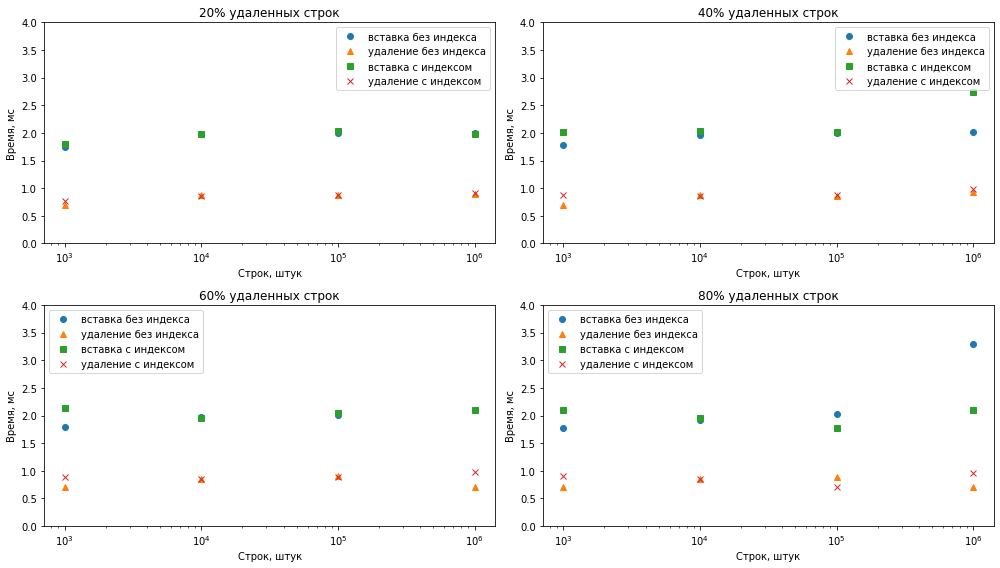

In [25]:
mean_result = result.groupby(level=["size", "with_index", "deleted_percent", "qtype"]).mean()
std_result = result.groupby(level=["size", "with_index", "deleted_percent", "qtype"]).std()

fig, axs = plt.subplots(2, int(np.ceil(len(DELETED_PERCENTS) / 2)), figsize=(14,8))

for deleted_percent, ax in zip(DELETED_PERCENTS, axs.flat):
    ax.set_title(f"{int(deleted_percent * 100)}% удаленных строк")
    ax.set_xscale('log')
    ax.set_ylim(0, 4)
    ax.set_ylabel('Время, мс')
    ax.set_xlabel('Строк, штук')

    for i, params in enumerate(itertools.product(WITH_INDEX, ["insert", "delete"])):
        with_index, qtype = params
        qtype_text = "вставка" if qtype == "insert" else "удаление"
        with_index_text = "с индексом" if with_index else "без индекса"
        ax.errorbar(
            DBSIZES,
            mean_result.xs(
                (deleted_percent, with_index, qtype), 
                level=["deleted_percent", "with_index", "qtype"]
            )["time"],
#             yerr=std_result.xs(
#                 (deleted_percent, with_index, qtype), 
#                 level=["deleted_percent", "with_index", "qtype"]
#             )["time"],
            fmt=("o", "^", "s", "x")[i],
            label=f"{qtype_text} {with_index_text}",
            capsize=(i+1)*3,
        )
    ax.legend()
plt.tight_layout()
fig.savefig("insert-delete-graph.pdf", format="pdf", bbox_inches="tight")

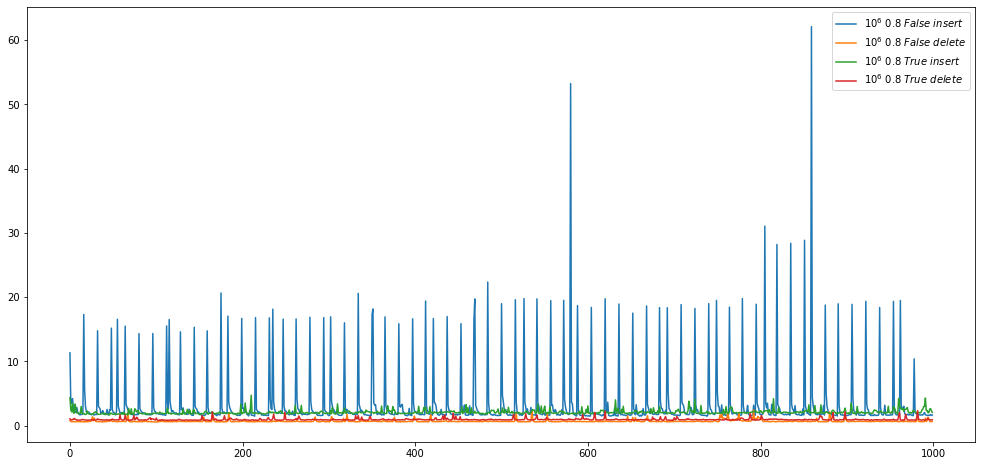

In [28]:
plt.figure(figsize=(17, 8))
for size, deleted_percent, with_index, qtype in itertools.product(DBSIZES[-1:], DELETED_PERCENTS[-1:], WITH_INDEX, ["insert", "delete"]):
    measures = result.xs(
            (size, deleted_percent, with_index, qtype), 
            level=["size", "deleted_percent", "with_index", "qtype"])["time"]
    plt.plot(
        range(len(measures)),
        measures,
        label=f"$10^{np.log10(size):1.0f} \ {deleted_percent} \ {with_index} \ {qtype}$"
    )
plt.legend()

## Измерение влияние индекса на сложный запрос

In [267]:
DELETED_PERCENTS = [0.25, 0.75] # [0.2, 0.4, 0.6, 0.8]
WITH_INDEX = (False, True)
DBSIZES = [1_000, 10_000] # 100_000] #, 1_000_000]
WITH_RESTART_DB=(True,),

result = get_measurement_results(
    DBSIZES = DBSIZES,
    WITH_INDEX = WITH_INDEX,
    DELETED_PERCENTS = DELETED_PERCENTS,
    WITH_RESTART_DB=(True,),
    QUERY_PARAMS = [
        {"qtype": "join", "soft_delete": True},
    ],
    MEASURES = 10,
)

  0%|          | 0/80 [00:00<?, ?it/s]

Create users:   0%|          | 0/2 [00:00<?, ?it/s]

Create user forms:   0%|          | 0/2 [00:00<?, ?it/s]

Delete 25.0% of database:   0%|          | 0/500 [00:00<?, ?it/s]

Delete 75.0% of database:   0%|          | 0/1500 [00:00<?, ?it/s]

Delete 25.0% of database:   0%|          | 0/500 [00:00<?, ?it/s]

Delete 75.0% of database:   0%|          | 0/1500 [00:00<?, ?it/s]

Create users:   0%|          | 0/20 [00:00<?, ?it/s]

Create user forms:   0%|          | 0/20 [00:00<?, ?it/s]

Delete 25.0% of database:   0%|          | 0/5000 [00:00<?, ?it/s]

Delete 75.0% of database:   0%|          | 0/15000 [00:00<?, ?it/s]

Delete 25.0% of database:   0%|          | 0/5000 [00:00<?, ?it/s]

Delete 75.0% of database:   0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
# result.to_csv("join-graph.csv")

In [6]:
DELETED_PERCENTS = [0.2, 0.4, 0.6, 0.8]
DBSIZES = [1_000, 10_000, 100_000]
result = pd.read_csv("2022-07-31T21:14-join-graph.csv", index_col=["with_restart", "size", "with_index", "deleted_percent", "qtype", "table", "soft_delete", "measure_i"])

In [10]:
mean_result

time
size   with_index deleted_percent qtype           
1000   False      0.2             join     3.94516
                  0.4             join     3.53422
                  0.6             join     2.96140
                  0.8             join     2.09335
       True       0.2             join     4.10272
                  0.4             join     3.03305
                  0.6             join     2.43794
                  0.8             join     2.17730
10000  False      0.2             join    21.02650
                  0.4             join    16.07080
                  0.6             join    11.79278
                  0.8             join     7.88674
       True       0.2             join    20.06747
                  0.4             join    14.96567
                  0.6             join    10.89933
                  0.8             join     6.82328
100000 False      0.2             join   172.85672
                  0.4             join   174.91351
                  0.6             join    94.00614
                  0.8             join    64.27826
       True       0.2             join   180.38862
                  0.4             join   124.40835
                  0.6             join   109.63907
                  0.8             join    68.07902

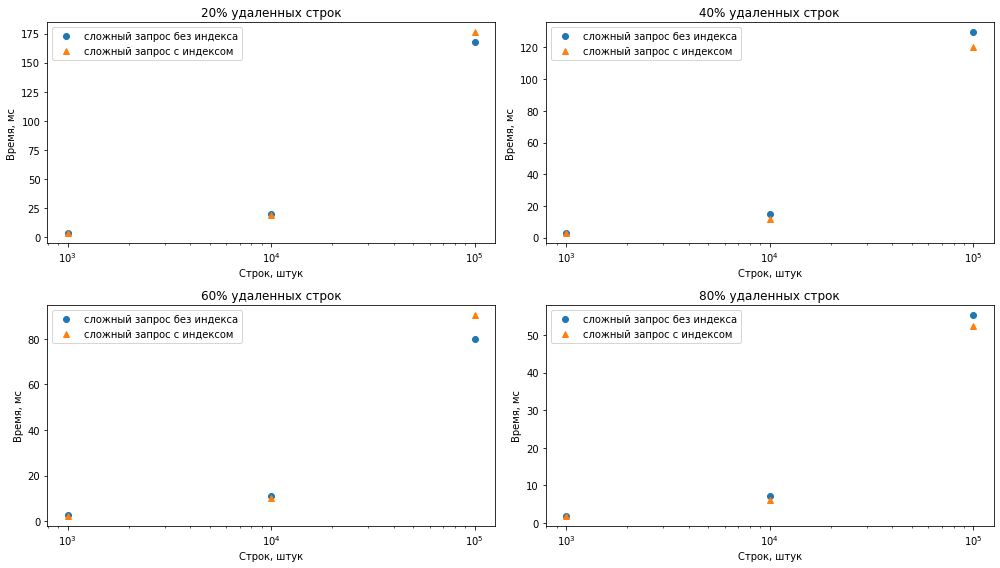

In [13]:
mean_result = result.groupby(level=["size", "with_index", "deleted_percent", "qtype"]).mean()
std_result = result.groupby(level=["size", "with_index", "deleted_percent", "qtype"]).std()

fig, axs = plt.subplots(2, int(np.ceil(len(DELETED_PERCENTS) / 2)), figsize=(14,8))

for deleted_percent, ax in zip(DELETED_PERCENTS, axs.flat):
    ax.set_title(f"{int(deleted_percent * 100)}% удаленных строк")
    ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set_ylabel('Время, мс')
    ax.set_xlabel('Строк, штук')

    for i, params in enumerate(itertools.product(WITH_INDEX, ["join"])):
        with_index, qtype = params
        qtype_text = "сложный запрос"
        with_index_text = "с индексом" if with_index else "без индекса"
        x = DBSIZES
        y = mean_result.xs(
                (deleted_percent, with_index, qtype), 
                level=["deleted_percent", "with_index", "qtype"]
            )["time"]
#         print(x, y)
        ax.errorbar(
            x,
            y,
#             yerr=std_result.xs(
#                 (deleted_percent, with_index, qtype), 
#                 level=["deleted_percent", "with_index", "qtype"]
#             )["time"],
            fmt=("o", "^", "s", "x")[i],
            label=f"{qtype_text} {with_index_text}",
            capsize=(i+1)*3,
        )
    ax.legend()
plt.tight_layout()
fig.savefig("join-graph.pdf", format="pdf", bbox_inches="tight")

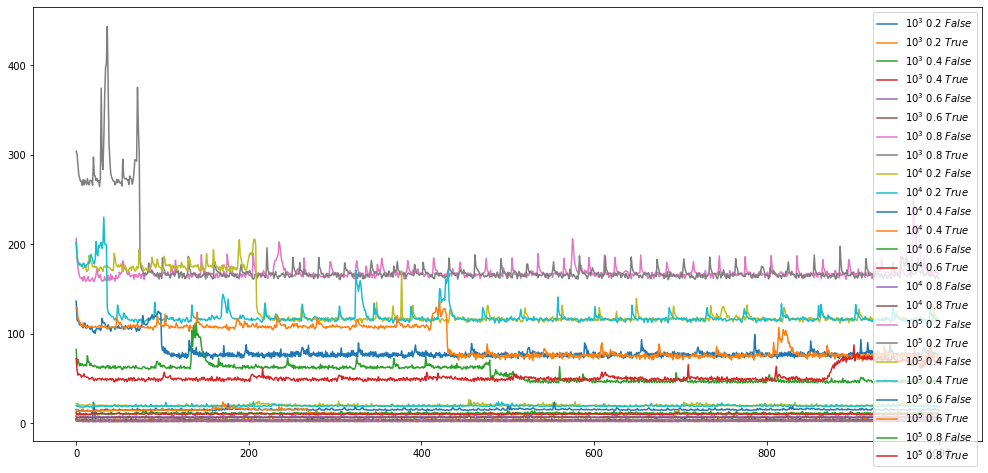

In [8]:
plt.figure(figsize=(17, 8))
for size, deleted_percent, with_index, qtype in itertools.product(DBSIZES, DELETED_PERCENTS, WITH_INDEX, ["join"]):
    measures = result.xs(
            (size, deleted_percent, with_index, qtype), 
            level=["size", "deleted_percent", "with_index", "qtype"])["time"]
    plt.plot(
        range(len(measures)),
        measures,
        label=f"$10^{np.log10(size):1.0f} \ {deleted_percent} \ {with_index}$"
    )
plt.legend()

'2022-07-31T21:04'